In [7]:
import sys

sys.path.append("../misc")
import onnx
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torchvision import transforms
from PIL import Image
from utils import load_class_label, extract_cifar, unpickle, fuse_single_conv_bn_pair
import torch.nn as nn
from utils import DataShaper, count_parameters
import os
import math
import numpy as np
from numpy import load
import numpy

torch.manual_seed(0)
import resnet_projected as res
import time
from brevitas.nn import QuantConv2d, QuantIdentity, QuantReLU
from brevitas.quant.fixed_point import (
    Int8ActPerTensorFixedPoint,
    Int8WeightPerTensorFixedPoint,
    Uint8ActPerTensorFixedPoint,
)
from brevitas.graph.target.flexml import preprocess_for_flexml_quantize
from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model
import torch.utils.data as data_utils
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate_bn
from brevitas_examples.imagenet_classification.utils import generate_dataloader
from brevitas_examples.imagenet_classification.utils import SEED
from brevitas_examples.imagenet_classification.utils import validate

ds = DataShaper()


# LOAD THE GOLDEN MODEL
num_classes = 10
offload_model = res.Resnet50(num_classes)
base_model = res.Resnet50(num_classes)

weights = "../misc/weights_CIFAR_CUDA_Resnet50_0.0001_01_29_2024/CIFAR_CUDA_Resnet50_weight_100.tar"
# offload_model=res.Resnet50ACDC(num_classes)
# weights="../misc/weights_CIFAR_Resnet50ACDC_0.0001_01_28_2024/CIFAR_Resnet50ACDC_weight_0.tar"
saved_model_dict = torch.load(weights, map_location=torch.device("cpu"))
offload_model.load_state_dict(saved_model_dict)
base_model.load_state_dict(saved_model_dict)


data_dir = "data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor(),
    ]
)
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, transform=transform_train, download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, transform=transform_test, download=True
)

# Data loader
indices = torch.arange(256)
tr_sub = data_utils.Subset(train_dataset, indices)
val_sub = data_utils.Subset(test_dataset, indices)
calib_loader = torch.utils.data.DataLoader(dataset=tr_sub, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_sub, batch_size=64, shuffle=False)


# flexml requires static shapes, pass a representative input in
img_shape = 32

base_model.eval()
cifar_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def Average(lst):
    return sum(lst) / len(lst)

Files already downloaded and verified
Files already downloaded and verified


____________________________________IMAGE 0____________________________________________
Time (msec): 427.32666015625
 Predicted CPU: cat
____________________________________IMAGE 1____________________________________________
Time (msec): 379.242431640625
 Predicted CPU: ship
____________________________________IMAGE 2____________________________________________
Time (msec): 390.9765625
 Predicted CPU: ship
____________________________________IMAGE 3____________________________________________
Time (msec): 322.4619140625
 Predicted CPU: ship
____________________________________IMAGE 4____________________________________________
Time (msec): 313.78271484375
 Predicted CPU: frog
____________________________________IMAGE 5____________________________________________
Time (msec): 297.677490234375
 Predicted CPU: frog
____________________________________IMAGE 6____________________________________________
Time (msec): 329.52587890625
 Predicted CPU: automobile
________________________________

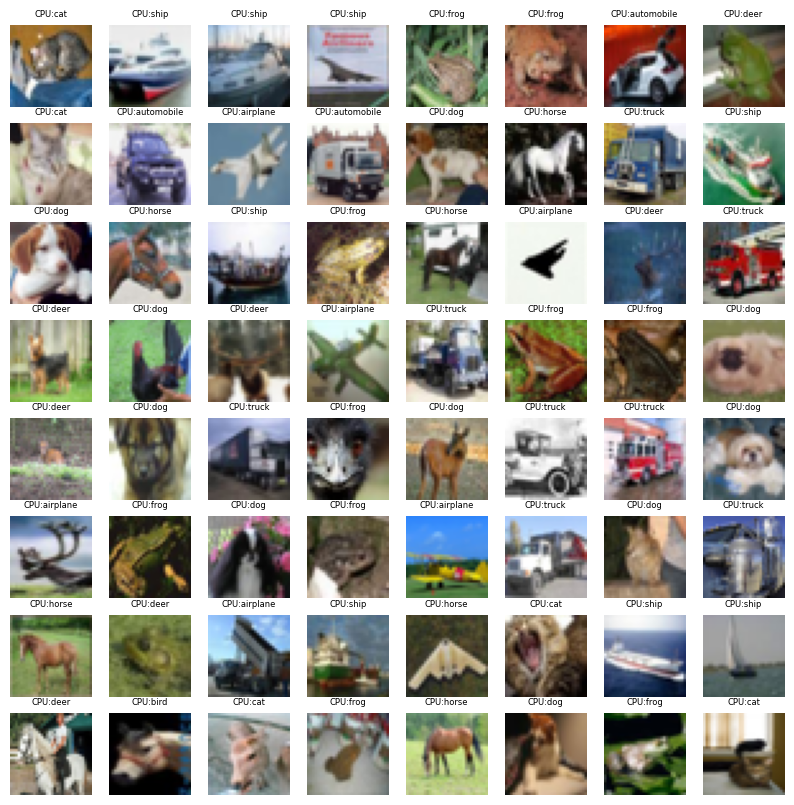

In [9]:
##### import matplotlib.pyplot as plt
import numpy as np
import time

predicted_label = [None] * 64
cpu_predicted_label = [None] * 64
cpu_time = [None] * 64

# input_batch = input_tensor.unsqueeze(0)
metafile = r"./data/cifar-10-batches-py/batches.meta"
datafile = r"./data/cifar-10-batches-py/test_batch"
data_batch_1 = unpickle(datafile)
metadata = unpickle(metafile)
labels = data_batch_1["labels"]
label_path = "data/cifar10_label_map.txt"
model_num_classes = 10
class_label_map = load_class_label(label_path, model_num_classes)
quant_id_1 = QuantIdentity(
    act_quant=Uint8ActPerTensorFixedPoint, bit_width=8, return_quant_tensor=True
)
quant_id_1.eval()
for i in range(0, 64):
    print(
        "____________________________________IMAGE {}____________________________________________".format(
            i
        )
    )
    image_name = f"./cifar_images/image_{i}.png"
    img = Image.open(image_name)
    input_tensor = cifar_test_transform(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        # print(input_batch.shape
        start = time.time() * 1000

        final_output_base = base_model(input_batch)
        # AIE OFFLOAD

        end = time.time() * 1000
        cpu_time[i] = end - start
        print("Time (msec):", end - start)

        cpu_predicted_class = np.argmax(final_output_base)
        cpu_predicted_label[i] = metadata["label_names"][cpu_predicted_class]

        label = metadata["label_names"][labels[i]]
        print(f" Predicted CPU: {cpu_predicted_label[i]}")

        # Calculate the five categories with the highest classification probability
        golden_prediction_class_index = (
            torch.topk(final_output_base, k=5, sorted=True).indices.squeeze(0).tolist()
        )

import matplotlib.pyplot as plt

average = Average(cpu_time)
fig, axs = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    img = Image.open("./cifar_images/image_" + str(i) + ".png")
    ax.imshow(img)
    ax.axis("off")  # to hide the axes
    ax.set_title("CPU:" + cpu_predicted_label[i], fontsize=6)

print("Average::", average)